## Deep Neural Network model: Hyperparameter tuning
*Summary:* In this notebook, we search for the most optimal hyperparameters based on Bayesian search for both binary and multi-label classification models. The dataset is first encoded one-hot and standardized. 

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

train = pd.read_csv("../dataset/UNSW_NB15_training-set.csv")
test = pd.read_csv("../dataset/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test]).reset_index(drop=True)
df = df.drop(columns=["id"])
df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
257669,0.505762,tcp,-,FIN,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.98057,3721.068786,120.177727,255,3518776216,3453092386,255,0.09944,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,1
257670,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
257671,0.000009,udp,dns,INT,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [2]:
labels = df['label']
mc_labels = df['attack_cat']
x_df = df.drop(columns=['label', 'attack_cat']).reset_index(drop=True)

### Preprocessing

In [3]:
cat_cols = x_df.select_dtypes(exclude=np.number).columns
num_cols = x_df.select_dtypes(include=np.number).columns

one_hot_cat = []
for cat in cat_cols:
    one_hot_cat.append(pd.get_dummies(x_df[cat]))

x_df = pd.concat([x_df[num_cols]] + one_hot_cat, axis=1)
x_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,3pc,a/n,aes-sp3-d,any,argus,aris,arp,ax.25,bbn-rcc,bna,br-sat-mon,cbt,cftp,chaos,compaq-peer,cphb,cpnx,crtp,crudp,dcn,ddp,ddx,dgp,egp,eigrp,emcon,encap,etherip,fc,fire,ggp,gmtp,gre,hmp,i-nlsp,iatp,ib,icmp,idpr,idpr-cmtp,idrp,ifmp,igmp,igp,il,ip,ipcomp,ipcv,ipip,iplt,ipnip,ippc,ipv6,ipv6-frag,ipv6-no,ipv6-opts,ipv6-route,ipx-n-ip,irtp,isis,iso-ip,iso-tp4,kryptolan,l2tp,larp,leaf-1,leaf-2,merit-inp,mfe-nsp,mhrp,micp,mobile,mtp,mux,narp,netblt,nsfnet-igp,nvp,ospf,pgm,pim,pipe,pnni,pri-enc,prm,ptp,pup,pvp,qnx,rdp,rsvp,rtp,rvd,sat-expak,sat-mon,sccopmce,scps,sctp,sdrp,secure-vmtp,sep,skip,sm,smp,snp,sprite-rpc,sps,srp,st2,stp,sun-nd,swipe,tcf,tcp,tlsp,tp++,trunk-1,trunk-2,ttp,udp,unas,uti,vines,visa,vmtp,vrrp,wb-expak,wb-mon,wsn,xnet,xns-idp,xtp,zero,-,dhcp,dns,ftp,ftp-data,http,irc,pop3,radius,smtp,snmp,ssh,ssl,ACC,CLO,CON,ECO,FIN,INT,PAR,REQ,RST,URN,no
0,0.000011,2,0,496,0,90909.090200,254,0,1.803636e+08,0.000000,0,0,0.011000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.000008,2,0,1762,0,125000.000300,254,0,8.810000e+08,0.000000,0,0,0.008000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.000005,2,0,1068,0,200000.005100,254,0,8.544000e+08,0.000000,0,0,0.005000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.000006,2,0,900,0,166666.660800,254,0,6.000000e+08,0.000000,0,0,0.006000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0.000010,2,0,2126,0,100000.002500,254,0,8.504000e+08,0.000000,0,0,0.010000,0.00000,0.000000,0.000000,0,0,0,0,0.00000,0.000000,0.000000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

### Classification models: Hyperparameter tuning

Split the dataset into train, test sets with a test set size of 0.2 of total size 

In [4]:
from sklearn.model_selection import train_test_split

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(x_df, labels, stratify=labels, test_size=.2, random_state=42)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(x_df, mc_labels, stratify=mc_labels, test_size=.2, random_state=42)

print(f"Binary model split:      X = {X_train_binary.shape, X_test_binary.shape}, Y = {y_train_binary.shape, y_test_binary.shape}")
print(f"Multi-class model split: X = {X_train_multi.shape, X_test_multi.shape}, Y = {y_train_multi.shape, y_test_multi.shape}")

Binary model split:      X = ((206138, 196), (51535, 196)), Y = ((206138,), (51535,))
Multi-class model split: X = ((206138, 196), (51535, 196)), Y = ((206138,), (51535,))


We standardize the numerical features to satisfy the assumption that many ML models have on the provided data.

In [5]:
from sklearn.preprocessing import StandardScaler

n_num_cols = len(num_cols)
sc_binary = StandardScaler()
X_train_binary.iloc[:, :n_num_cols] = sc_binary.fit_transform(X_train_binary.iloc[:, :n_num_cols])
X_test_binary.iloc[:, :n_num_cols] = sc_binary.transform(X_test_binary.iloc[:, :n_num_cols])

sc_multi = StandardScaler()
X_train_multi.iloc[:, :n_num_cols] = sc_multi.fit_transform(X_train_multi.iloc[:, :n_num_cols])
X_test_multi.iloc[:, :n_num_cols] = sc_multi.transform(X_test_multi.iloc[:, :n_num_cols])

### Bayesian optimization

To find the appropriate hyper-parameter values, we can search the parameter space, which may be high dimensional but reduces to a straight-forward search problem. In the case of deep neural networks, it is inadvisable to use a systematic or random approach to find the optimal hyper-parameters, as the 'function' that we want to optimize is expensive to probe. Instead, as pointed out by the literature (https://proceedings.neurips.cc/paper_files/paper/2012/file/05311655a15b75fab86956663e1819cd-Paper.pdf), we opt for the Bayesian optimization method for the DNN model. In Baysian optimization, the black-box function is probed multiple times to produce a prior probability distribution which results in a belief about the function to optimize. The optimizer builds models based on what it has seen previously when probing the function.  

Relevant links:
- Code below: https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/ 
- hyperparam tuning: https://www.analyticsvidhya.com/blog/2021/05/bayesian-optimization-bayes_opt-or-hyperopt/ 
- python package: https://github.com/fmfn/BayesianOptimization
- video explaining: https://www.youtube.com/watch?v=vz3D36VXefI&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=11 

In [6]:
# Import packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings

warnings.filterwarnings('ignore')

In [7]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

# optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
# activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
#                    'elu', 'exponential', 'LeakyReLU', 'relu']

### Binary model tuning

In [8]:
def binary_bayes_opt_cv(neurons_l1,
                       layer2, neurons_l2,
                       layer3, neurons_l3,
                       layer4, neurons_l4,
                       batch_size, epochs,
                       normalization, dropout, dropout_rate):

    neurons_l1 = round(neurons_l1)
    neurons_l2 = round(neurons_l2)
    neurons_l3 = round(neurons_l3)
    neurons_l4 = round(neurons_l4)
    batch_size = round(batch_size)
    epochs = round(epochs)

    def create_nn():
        nn = Sequential()
        nn.add(Dense(neurons_l1, input_dim=X_train_multi.shape[1], activation='relu'))
        if normalization > 0.5:
            nn.add(BatchNormalization())
            
        if layer2 > 0.5: 
            nn.add(Dense(neurons_l2, activation='relu'))

        if dropout > 0.5:
            nn.add(Dropout(rate=dropout_rate))

        if layer3 > 0.5: 
            nn.add(Dense(neurons_l3, activation='relu'))

        if layer4 > 0.5: 
            nn.add(Dense(neurons_l4, activation='relu'))
    
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return nn
    
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=create_nn, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train_binary, y_train_binary, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [9]:
param_grid_binary ={
    'neurons_l1': (5,100),    
    'layer2': (0,1),
    'neurons_l2': (5,100),
    'layer3': (0,1),
    'neurons_l3': (5,100),
    'layer4': (0,1),
    'neurons_l4': (5,100),
    'batch_size':(32, 1024),
    'epochs':(25, 500),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}

In [10]:
B_HYPER_PARAM_PATH = "../dnn_hyperparams/b_hyperparam_logs.json"

#### Optimize

In [11]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path=B_HYPER_PARAM_PATH)

acquisition_function = UtilityFunction(kind="ei", xi=0.05)

b_bo = BayesianOptimization(
    f=binary_bayes_opt_cv, 
    pbounds=param_grid_binary, 
    verbose=2,
    random_state=111)

# Safe params by subscribing
b_bo.subscribe(Events.OPTIMIZATION_STEP, logger)

b_bo.maximize(
    init_points=25, 
    n_iter=10,
    acquisition_function=acquisition_function)

1289/1289 [==============================] - 2s 1ms/step


KeyboardInterrupt: 

#### Load hyperparam logs

In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

acquisition_function = UtilityFunction(kind="ei", xi=0.05)

new_b_bo = BayesianOptimization(
    f=binary_bayes_opt_cv, 
    pbounds=param_grid_binary, 
    verbose=2,
    random_state=111)

# Safe params by subscribing
new_b_bo.subscribe(Events.OPTIMIZATION_STEP, logger)
# New optimizer is loaded with previously seen points
load_logs(new_b_bo, logs=[B_HYPER_PARAM_PATH])

In [ ]:
new_b_bo.maximize(
    init_points=25, 
    n_iter=10,
    acquisition_function=acquisition_function)

#### Best params

In [23]:
b_params = b_bo.max['params']
b_params['batch_size'] = round(b_params['batch_size'])
b_params['epochs']     = round(b_params['epochs'])
b_params['neurons_l1'] = round(b_params['neurons_l1'])
b_params['neurons_l2'] = round(b_params['neurons_l2'])
b_params['neurons_l3'] = round(b_params['neurons_l3'])
b_params['neurons_l4'] = round(b_params['neurons_l4'])

b_params, b_bo.max['target']

({'batch_size': 540,
  'dropout': 0.8430821100890739,
  'dropout_rate': 0.028454008433744526,
  'epochs': 407,
  'layer2': 0.06222815231149381,
  'layer3': 0.6354944773255249,
  'layer4': 0.9687811501818422,
  'neurons_l1': 43,
  'neurons_l2': 68,
  'neurons_l3': 25,
  'neurons_l4': 90,
  'normalization': 0.9866316190262712},
 0.9395162520610703)

#### Test binary model

In [13]:
X_val_binary = X_train_binary.iloc[-10000:]
y_val_binary = y_train_binary.iloc[-10000:]
X_train_binary = X_train_binary.iloc[:-10000]
y_train_binary = y_train_binary.iloc[:-10000]

print("Binary model")
print(f"  Training dataset:   {(X_train_binary.shape, y_train_binary.shape)}")
print(f"  validation dataset: {(X_val_binary.shape, y_val_binary.shape)}")

Binary model
  Training dataset:   ((196138, 196), (196138,))
  validation dataset: ((10000, 196), (10000,))


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [15]:
def create_binary_model():
    model = Sequential()
    model.add(Dense(b_params["neurons_l1"], input_dim=X_train_binary.shape[1], activation='relu'))
    if b_params["normalization"] > 0.5:
        model.add(BatchNormalization())
        
    if b_params["layer2"] > 0.5: 
        model.add(Dense(b_params["neurons_l2"], activation='relu'))

    if b_params["dropout"] > 0.5:
        model.add(Dropout(rate=b_params["dropout_rate"]))

    if b_params["layer3"] > 0.5: 
        model.add(Dense(b_params["neurons_l3"], activation='relu'))

    if b_params["layer4"] > 0.5: 
        model.add(Dense(b_params["neurons_l4"], activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_binary_model()
model.summary()

Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_550 (Dense)           (None, 43)                8471      
                                                                 
 batch_normalization_70 (Bat  (None, 43)               172       
 chNormalization)                                                
                                                                 
 dropout_95 (Dropout)        (None, 43)                0         
                                                                 
 dense_551 (Dense)           (None, 25)                1100      
                                                                 
 dense_552 (Dense)           (None, 90)                2340      
                                                                 
 dense_553 (Dense)           (None, 1)                 91        
                                                    

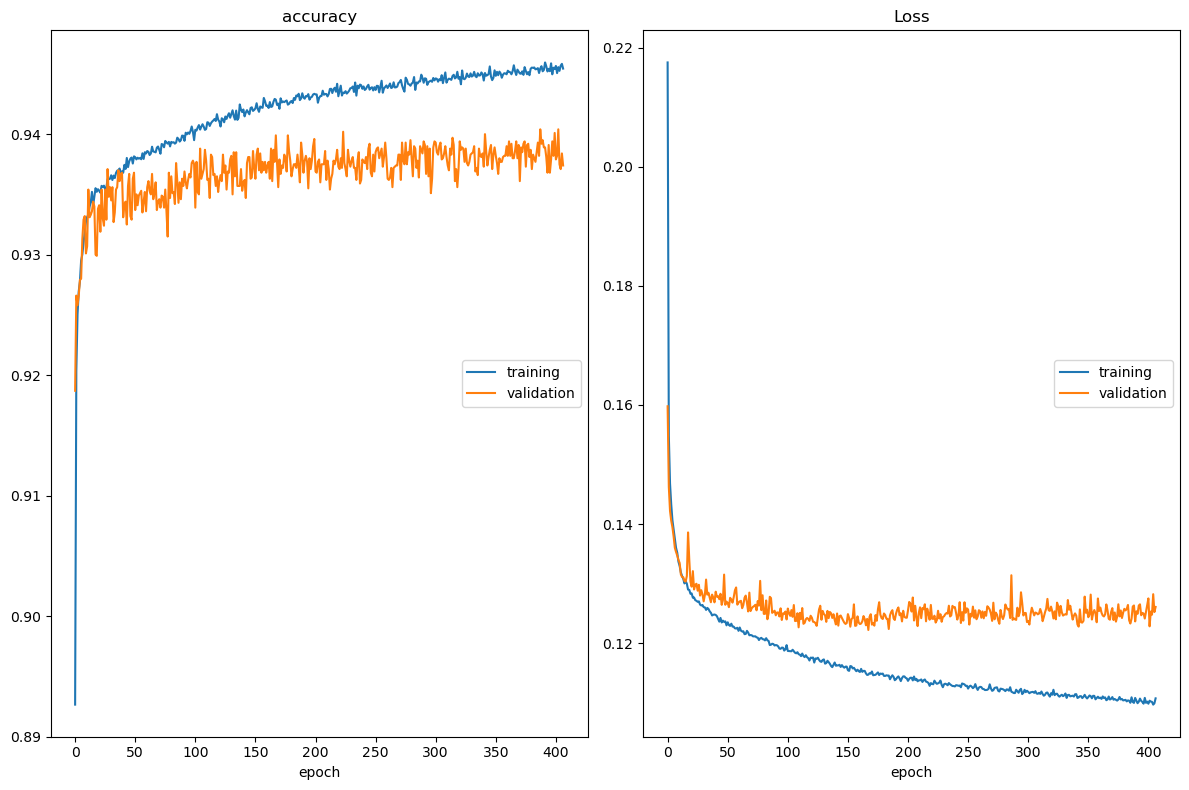

accuracy
	training         	 (min:    0.893, max:    0.946, cur:    0.945)
	validation       	 (min:    0.919, max:    0.940, cur:    0.937)
Loss
	training         	 (min:    0.110, max:    0.218, cur:    0.111)
	validation       	 (min:    0.122, max:    0.160, cur:    0.126)
364/364 - 2s - loss: 0.1107 - accuracy: 0.9454 - val_loss: 0.1261 - val_accuracy: 0.9374 - 2s/epoch - 4ms/step


In [16]:
EPOCHS = b_params["epochs"]
BATCH_SIZE = b_params["batch_size"]

history = model.fit(X_train_binary,
                    y_train_binary, 
                    validation_data=(X_val_binary, y_val_binary),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras()])

In [17]:
y_pred = model.predict(X_test_binary)
y_pred = y_pred.reshape((y_pred.shape[0],))

1611/1611 [==============================] - 2s 964us/step


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_binary, y_pred.round())
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(labels.unique())))

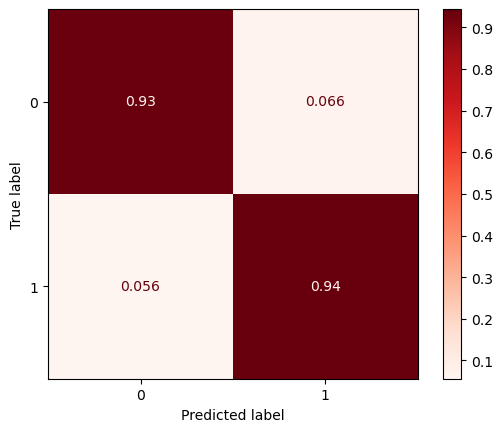

In [19]:
import matplotlib.pyplot as plt

disp.plot(cmap=plt.cm.Reds, xticks_rotation=0)

In [20]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score

ys = y_test_binary
ys_pred = y_pred.round()

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred)}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred)}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred)}")

Accuracy score:                   0.9403124090423983
Matthews correlation coefficient: 0.8717992100432422
recall score (weighted):          0.9441323819644755
precision score (weighted):       0.9617704370418484
f1 score (weighted):              0.9528697943799223


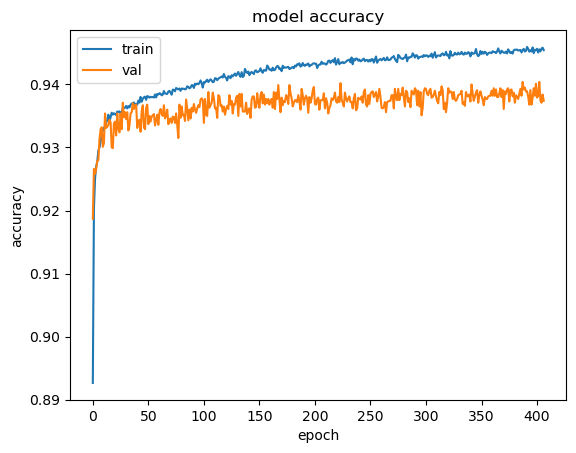

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

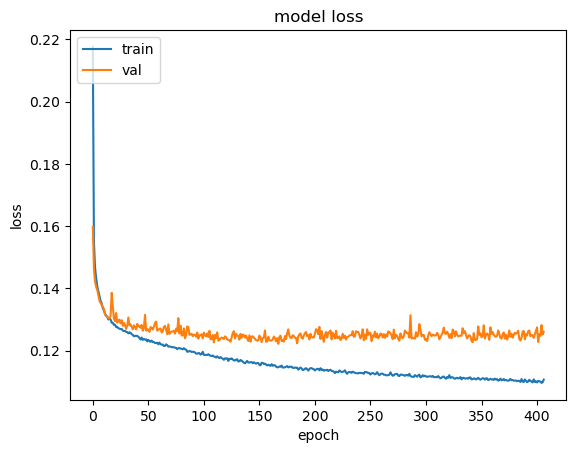

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Multi-class model tuning

In [21]:
def multi_bayes_opt_cv(neurons_l1,
                       layer2, neurons_l2,
                       layer3, neurons_l3,
                       layer4, neurons_l4,
                       batch_size, epochs,
                       normalization, dropout, dropout_rate):

    neurons_l1 = round(neurons_l1)
    neurons_l2 = round(neurons_l2)
    neurons_l3 = round(neurons_l3)
    neurons_l4 = round(neurons_l4)
    batch_size = round(batch_size)
    epochs = round(epochs)

    def create_nn():
        nn = Sequential()
        nn.add(Dense(neurons_l1, input_dim=X_train_multi.shape[1], activation='relu'))
        if normalization > 0.5:
            nn.add(BatchNormalization())
            
        if layer2 > 0.5: 
            nn.add(Dense(neurons_l2, activation='relu'))

        if dropout > 0.5:
            nn.add(Dropout(rate=dropout_rate))

        if layer3 > 0.5: 
            nn.add(Dense(neurons_l3, activation='relu'))

        if layer4 > 0.5: 
            nn.add(Dense(neurons_l4, activation='relu'))
    
        nn.add(Dense(10, activation='softmax'))
        nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return nn
    
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=create_nn, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train_multi, y_train_multi, scoring=score_acc, cv=kfold, n_jobs=-1, fit_params={'callbacks':[es]}, verbose=0).mean()
    return score

In [22]:
param_grid_multi ={
    'neurons_l1': (20,200),    
    'layer2': (0,1),
    'neurons_l2': (20,200),
    'layer3': (0,1),
    'neurons_l3': (20,200),
    'layer4': (0,1),
    'neurons_l4': (20,200),
    'batch_size':(32, 1024),
    'epochs':(25, 500),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}

In [23]:
MC_HYPER_PARAM_PATH = "../dnn_hyperparams/mc_hyperparam_logs.json"

#### Optimize

In [24]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path=MC_HYPER_PARAM_PATH)

acquisition_function = UtilityFunction(kind="ei", xi=0.05)

mc_bo = BayesianOptimization(
    f=multi_bayes_opt_cv, 
    pbounds=param_grid_multi, 
    verbose=2,
    random_state=111)

# Safe params by subscribing
mc_bo.subscribe(Events.OPTIMIZATION_STEP, logger)

mc_bo.maximize(
    init_points=25, 
    n_iter=10,
    acquisition_function=acquisition_function)

#### Load hyperparam logs

In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

acquisition_function = UtilityFunction(kind="ei", xi=0.05)

new_mc_bo = BayesianOptimization(
    f=multi_bayes_opt_cv, 
    pbounds=param_grid_multi, 
    verbose=2,
    random_state=111)

# Safe params by subscribing
new_mc_bo.subscribe(Events.OPTIMIZATION_STEP, logger)
# New optimizer is loaded with previously seen points
load_logs(new_mc_bo, logs=[MC_HYPER_PARAM_PATH])

In [ ]:
new_mc_bo.maximize(
    init_points=25, 
    n_iter=10,
    acquisition_function=acquisition_function)

#### Best params

In [30]:
mc_params = mc_bo.max['params']
mc_params['batch_size'] = round(mc_params['batch_size'])
mc_params['epochs']     = round(mc_params['epochs'])
mc_params['neurons_l1'] = round(mc_params['neurons_l1'])
mc_params['neurons_l2'] = round(mc_params['neurons_l2'])
mc_params['neurons_l3'] = round(mc_params['neurons_l3'])
mc_params['neurons_l4'] = round(mc_params['neurons_l4'])

mc_params

{'batch_size': 296,
 'dropout': 0.8616525561059741,
 'dropout_rate': 0.2942475563821516,
 'epochs': 137,
 'layer2': 0.9229434419602413,
 'layer3': 0.5145623135225855,
 'layer4': 0.741083057050981,
 'neurons_l1': 27,
 'neurons_l2': 173,
 'neurons_l3': 151,
 'neurons_l4': 21,
 'normalization': 0.80849875291906}

#### Test multiclass model

In [38]:
X_val_multi = X_train_multi.iloc[-10000:]
y_val_multi = y_train_multi.iloc[-10000:]
X_train_multi = X_train_multi.iloc[:-10000]
y_train_multi = y_train_multi.iloc[:-10000]

print(f"Training dataset:   {(X_train_multi.shape, y_train_multi.shape)}")
print(f"validation dataset: {(X_val_multi.shape, y_val_multi.shape)}")

Training dataset:   ((196138, 196), (196138,))
validation dataset: ((10000, 196), (10000,))


In [46]:
y_train_multi = pd.get_dummies(y_train_multi)
y_val_multi = pd.get_dummies(y_val_multi)

In [47]:
def create_multiclass_model():
    model = Sequential()
    model.add(Dense(mc_params["neurons_l1"], input_dim=X_train_multi.shape[1], activation='relu'))
    if mc_params["normalization"] > 0.5:
        model.add(BatchNormalization())
        
    if mc_params["layer2"] > 0.5: 
        model.add(Dense(mc_params["neurons_l2"], activation='relu'))

    if mc_params["dropout"] > 0.5:
        model.add(Dropout(rate=mc_params["dropout_rate"]))

    if mc_params["layer3"] > 0.5: 
        model.add(Dense(mc_params["neurons_l3"], activation='relu'))

    if mc_params["layer4"] > 0.5: 
        model.add(Dense(mc_params["neurons_l4"], activation='relu'))

    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_multiclass_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 27)                5319      
                                                                 
 batch_normalization_2 (Batc  (None, 27)               108       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 173)               4844      
                                                                 
 dropout_2 (Dropout)         (None, 173)               0         
                                                                 
 dense_12 (Dense)            (None, 151)               26274     
                                                                 
 dense_13 (Dense)            (None, 21)                3192      
                                                      

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install livelossplot
from livelossplot import PlotLossesKeras

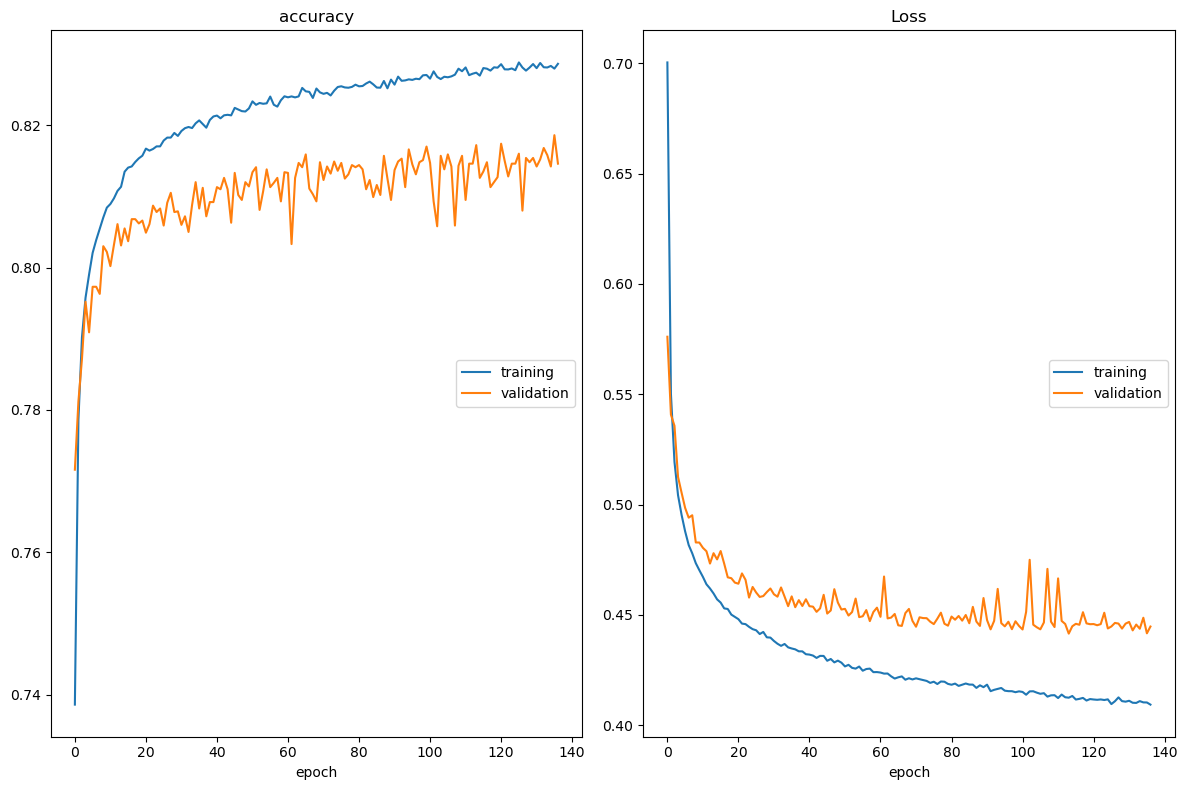

accuracy
	training         	 (min:    0.739, max:    0.829, cur:    0.829)
	validation       	 (min:    0.772, max:    0.819, cur:    0.815)
Loss
	training         	 (min:    0.409, max:    0.700, cur:    0.409)
	validation       	 (min:    0.442, max:    0.576, cur:    0.445)
663/663 - 3s - loss: 0.4094 - accuracy: 0.8286 - val_loss: 0.4448 - val_accuracy: 0.8146 - 3s/epoch - 5ms/step


In [48]:
EPOCHS = mc_params['epochs']
BATCH_SIZE = mc_params['batch_size']

history = model.fit(X_train_multi,
                    y_train_multi, 
                    validation_data=(X_val_multi, y_val_multi),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    verbose=2,
                    callbacks=[PlotLossesKeras()])

In [49]:
y_pred = model.predict(X_test_multi)

1611/1611 [==============================] - 2s 1ms/step


In [53]:
y_test_multi = pd.get_dummies(y_test_multi)

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_multi.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))
cm = np.around(cm / cm.astype('float').sum(axis=1, keepdims=True), decimals=3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(list(mc_labels.unique())))

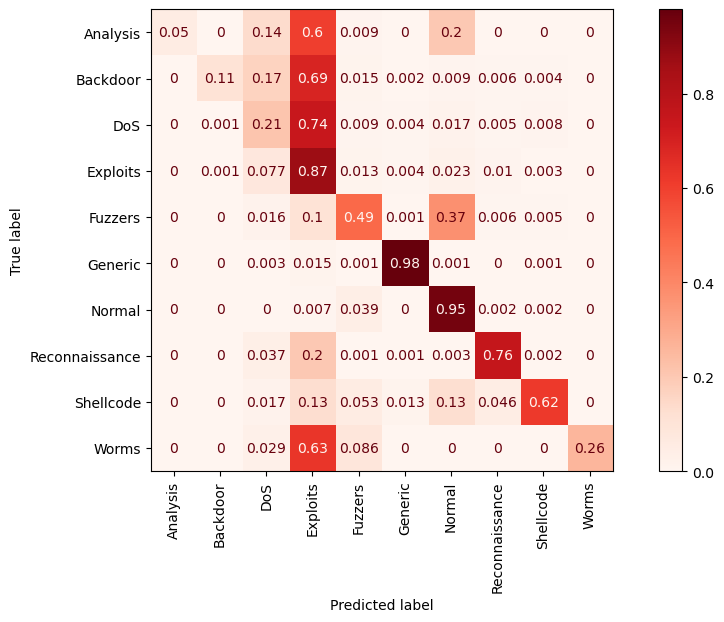

In [55]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)
disp.plot(cmap=plt.cm.Reds, xticks_rotation=90)

In [57]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, f1_score, auc

ys = y_test_multi.to_numpy().argmax(axis=1)
ys_pred = y_pred.argmax(axis=1)

print(f"Accuracy score:                   {accuracy_score(ys, ys_pred)}")
print(f"Matthews correlation coefficient: {matthews_corrcoef(ys, ys_pred)}")
print(f"recall score (weighted):          {recall_score(ys, ys_pred, average='weighted')}")
print(f"precision score (weighted):       {precision_score(ys, ys_pred, average='weighted')}")
print(f"f1 score (weighted):              {f1_score(ys, ys_pred, average='weighted')}")

Accuracy score:                   0.8224701659066653
Matthews correlation coefficient: 0.7693476455552456
recall score (weighted):          0.8224701659066653
precision score (weighted):       0.8204227685619421
f1 score (weighted):              0.8068735110700924
